## Q2

In [2]:
# import our needed libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random 
from numba import jit
import time 
from sklearn.datasets import load_iris
from skimage import color
from tqdm.notebook import tqdm
plt.rcParams['figure.figsize'] = (20, 10)


# Define our needed functions -------------------------------
# function for reading an image from its path
def reading_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

# showing an image by matplotlib library
def showing_image(image): 
    plt.figure()
    plt.imshow(image, cmap='gray')
    plt.show()
    
# this function is for handlling the edges for main algorithm
def gradient_image(img):
    
    # size of input image
    wi = img.shape[0]
    le = img.shape[1]
    
    # creating result 
    result = np.zeros(shape=(wi-1, le-1))
    
    # main loop 
    for i in tqdm(range(1, wi-1)):
        for j in range(1, le-1):
            gx = (img[i+1, j] - img[i-1, j])
            gy = (img[i, j+1] - img[i, j-1])
            result[i, j] = np.sum(gx ** 2 + gy ** 2)
            
    return result

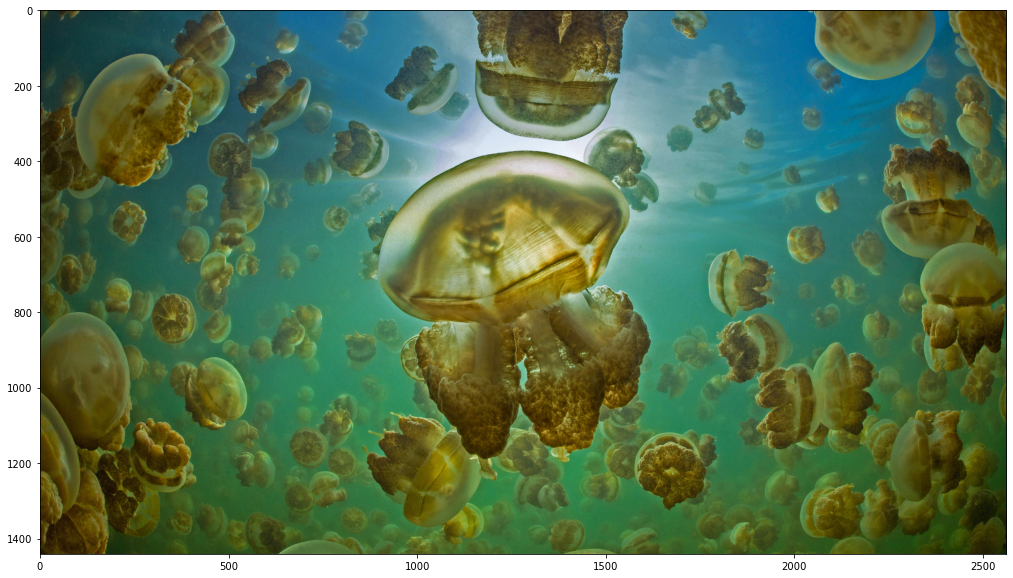

shape of original image :  (1441, 2561, 3)


In [6]:
# Reading our images
img_org = reading_image('GoldenJellyfish.jpg')
img3 = reading_image('result05.jpg')

# Showing the images
showing_image(img_org)
print('shape of original image : ', img_org.shape)


  0%|          | 0/1439 [00:00<?, ?it/s]

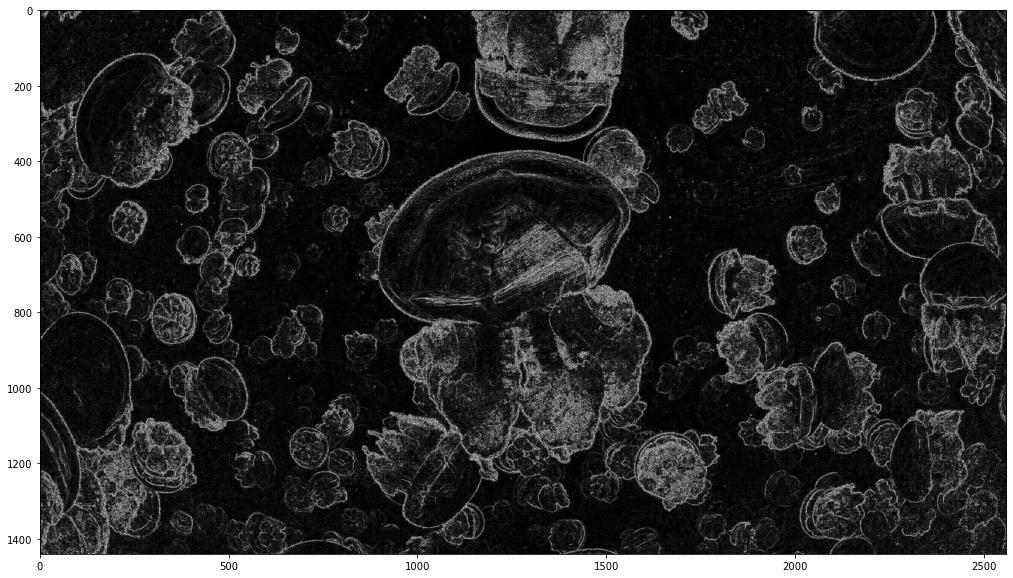

In [4]:

# transfering the image into Lab form 
img_org_lab = color.rgb2lab(img_org)
data = img_org_lab.copy()


# find critical edges
output1 = gradient_image(data)
output1 = output1.astype(np.uint8)
showing_image(output1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1441, 2561, 3)


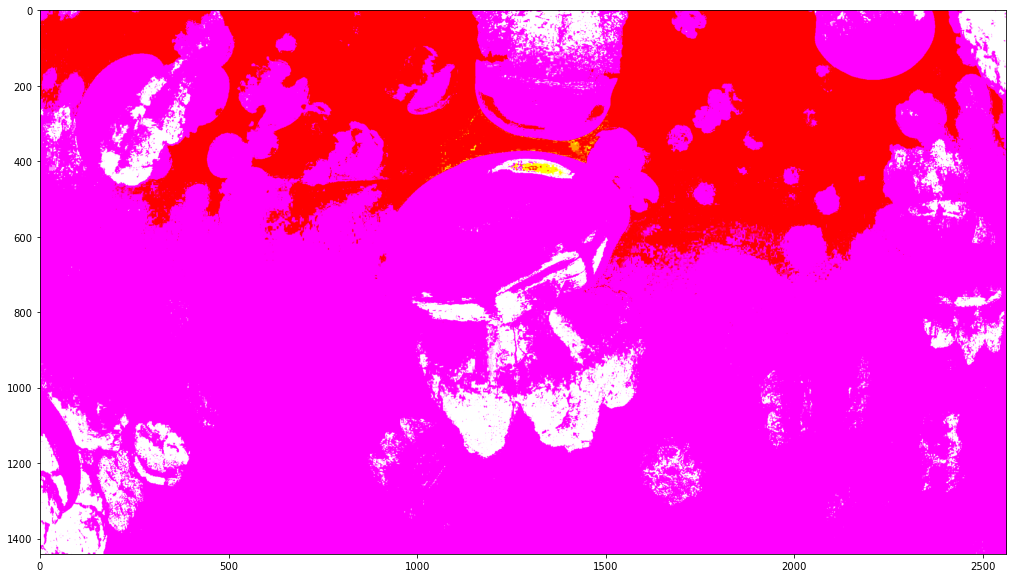

In [8]:
print(data.shape)

showing_image(data)

In [21]:
def slic(img,
         img2,
         n=1,
         k=16,
         centers_neighborhood=2,
         m=1
):
    
    # creating output
    out = np.zeros(img.shape)
    
    # img size and parameters
    wi = img.shape[0]
    le = img.shape[1]
    N = wi * le
    s = np.ceil((N / k) ** 0.5)
    print('s : ', s)
    
    
    # Intializing the centers
    cx, cy = np.meshgrid(np.arange(s, le-s, s), np.arange(s, wi-s, s))
    loc = np.stack((cx, cy), axis=2).astype(int)
    loc_shape = loc.shape
#     loc = loc.reshape(-1, 2)
#     print('loc shape : ', loc.shape)

    # concatenate with (x, y)s
    centers = img[loc[:, :, 1], loc[:, :, 0]]
    centers = np.concatenate((centers, loc), axis=2)
    print('centers shape : ', centers.shape)


    n1 = 3
    centers2 = centers.copy()
    for x in range(centers2.shape[0]):
        for y in range(centers2.shape[1]):
            
            cent_x = int(centers2[x, y, 3])
            cent_y = int(centers2[x, y, 4])
            
            min_neighbor = np.inf
            for i in range(np.max((cent_x-n1, 0)) , np.min((cent_x+n1+1, wi))):
                for j in range(np.max((cent_y-n1, 0)) , np.min((cent_y+n1+1, le))):
                    
#                     print('i : ', i)
#                     print('j : ', j)
#                     print('-----------')
                    if img2[i, j] < min_neighbor: 
                        min_neighbor = img2[i, j]
                        min_i = i
                        min_j = j

            centers2[x, y] = np.append(img[min_i, min_j], [min_i, min_j])
            
    centers = centers2.copy()
                




    # main loop over number of proceesing 
    for iteration in tqdm(range(n)):
        
        # creating states array incluing all centers values (x, y, point numbers)
        states = np.zeros(shape=(centers.shape[0], centers.shape[1], 3))
        
        # loop over all pixels of input image
        for x in tqdm(range(wi)):
            for y in range(le):

                # print report 
    #             print('x : ', x)
    #             print('y : ', y)


                # creating data for each pixel
                din = img[x, y]
                dxy = np.array([x, y]).reshape(1, 2)

                # finding nearest centers
                x_center = x // s
                y_center = y // s

                x_s = int(np.max((0, x_center - centers_neighborhood)))
                x_e = int(np.min((wi // s -1, x_center + 1 + centers_neighborhood)))

                y_s = int(np.max((0, y_center - centers_neighborhood)))
                y_e = int(np.min((le // s - 1, y_center + 1 + centers_neighborhood)))

    #             print('xs : ', x_s)
    #             print('xe : ', x_e)
    #             print('ys : ', y_s)
    #             print('ye : ', y_e)


                center = centers[x_s:x_e, y_s:y_e]
                center = center.reshape(-1, 5)

                # calculate d_lab distance
                dis = np.sum(((din - center[:, :3]) ** 2), axis=1).reshape(-1, 1)

                # adding d_xy distance
                dis += m * np.sum(((dxy - center[:, 3:]) ** 2), axis=1).reshape(-1, 1)

                # find the best location center among choosen centers
                indx = np.argmin(dis)
                
                # assign the pixel to the output
                out[x, y] = center[indx, :3]
                
                # find the best center location among all centers
                x_indx = (indx // (y_e - y_s)) + x_s
                y_indx = (indx % (y_e - y_s)) + y_s
                
                # assing the pixel to the best center
                states[x_indx, y_indx, 0] += x_s 
                states[x_indx, y_indx, 1] += y_s
                states[x_indx, y_indx, 2] += 1
                
                # complexity time
                m_sum = 0 
                for ti in range(wi):
                    m_sum += 1
                
                
                
        # end of checking all pixels
        
        
        # assign new place for each center
        states = states[:, :, 0:2] / states[:, :, 2].reshape(states.shape[0], states.shape[1], 1)
        centers[:, :, 3:] = states
        
        # showing result 
        out2 = img3.copy()
        
        
        
                


                
            

#     out = cv2.cvtColor(out, cv2.COLOR_LAB2RGB)
    return out2
            
            
                
    

s :  43.0
centers shape :  (32, 58, 5)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1441 [00:00<?, ?it/s]

/tmp/ipykernel_3322/1309093093.py:131: RuntimeWarning: invalid value encountered in true_divide
  states = states[:, :, 0:2] / states[:, :, 2].reshape(states.shape[0], states.shape[1], 1)


  0%|          | 0/1441 [00:00<?, ?it/s]

  0%|          | 0/1441 [00:00<?, ?it/s]

  0%|          | 0/1441 [00:00<?, ?it/s]

  0%|          | 0/1441 [00:00<?, ?it/s]

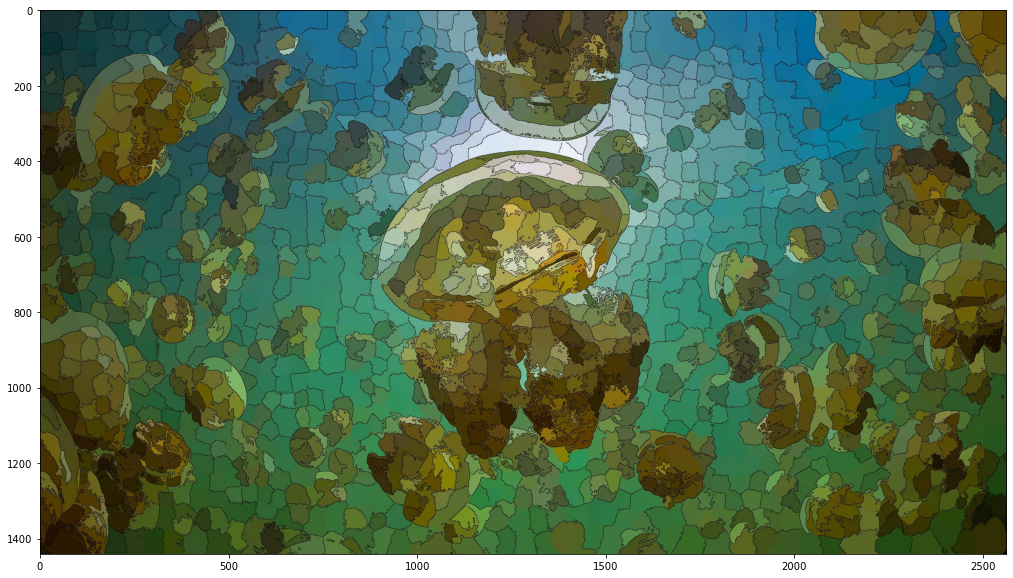

In [22]:

output = slic(data, output1, n=5, k=2048, centers_neighborhood=5, m=15)
showing_image(output)

In [23]:
result05 = cv2.cvtColor(output, cv2.COLOR_RGB2BGR)
cv2.imwrite('result01.jpg', result05)